In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
expr = pd.read_csv(
    "C:/Users/Aina Rif'ah/Downloads/INTERNSHIP/PROJECT 2/data/processed/GSE112509_log_normalized.csv",
    index_col=0
)

metadata = pd.read_csv(
    "C:/Users/Aina Rif'ah/Downloads/INTERNSHIP/PROJECT 2/data/processed/GSE112509_metadata.csv",
    index_col=0
)

expr.shape, metadata.shape



((29830, 79), (79, 6))

In [4]:
X = expr.T  # samples × genes
X.shape


(79, 29830)

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


C:\BLAST\envs\varpred\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\BLAST\envs\varpred\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\BLAST\envs\varpred\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\BLAST\envs\varpred\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

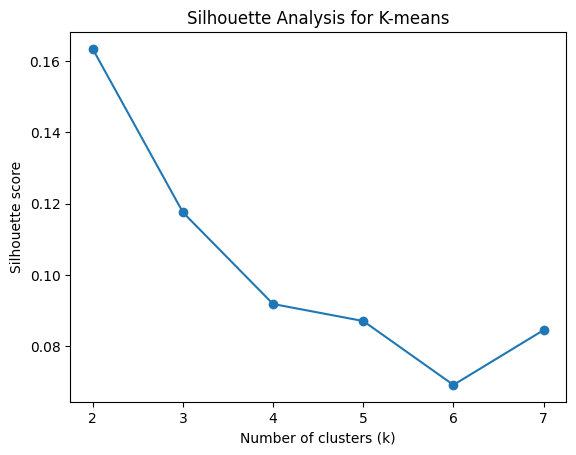

In [6]:
sil_scores = []

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

plt.plot(range(2, 8), sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Analysis for K-means")
plt.show()


In [7]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

metadata["KMeans_cluster"] = kmeans_labels
metadata.head()


C:\BLAST\envs\varpred\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,tissue,group,nevus type,braf mutation,nras mutation,condition,KMeans_cluster
GSM3071633,benign melanocytic nevi,Naevi_1,dermal,mut,wt,Benign,1
GSM3071634,benign melanocytic nevi,Naevi_1,dermal,mut,mut,Benign,1
GSM3071635,benign melanocytic nevi,Naevi_1,compound,mut,wt,Benign,1
GSM3071636,benign melanocytic nevi,Naevi_1,dermal,wt,mut,Benign,1
GSM3071637,benign melanocytic nevi,Naevi_1,dermal,mut,wt,Benign,0


In [8]:
sil_kmeans = silhouette_score(X_scaled, kmeans_labels)
db_kmeans = davies_bouldin_score(X_scaled, kmeans_labels)

sil_kmeans, db_kmeans


(0.1633711640587943, 1.9783436626562962)

In [9]:
linkage_matrix = linkage(X_scaled, method="ward")


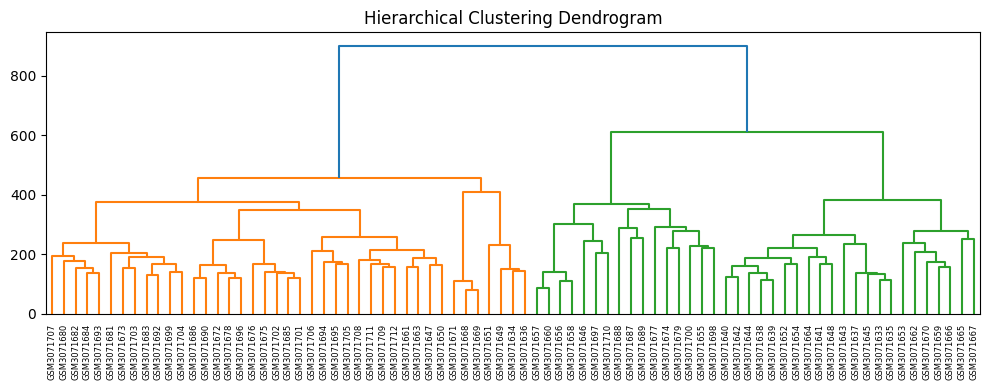

In [10]:
plt.figure(figsize=(10, 4))
dendrogram(linkage_matrix, labels=X.index, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.tight_layout()
plt.show()


In [11]:
hier_labels = fcluster(linkage_matrix, t=2, criterion="maxclust")
metadata["Hierarchical_cluster"] = hier_labels


In [12]:
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

metadata["DBSCAN_cluster"] = dbscan_labels


In [15]:
metadata.columns
metadata.head()


,tissue,group,nevus type,braf mutation,nras mutation,condition,KMeans_cluster,Hierarchical_cluster,DBSCAN_cluster
GSM3071633,benign melanocytic nevi,Naevi_1,dermal,mut,wt,Benign,1,2,-1
GSM3071634,benign melanocytic nevi,Naevi_1,dermal,mut,mut,Benign,1,1,-1
GSM3071635,benign melanocytic nevi,Naevi_1,compound,mut,wt,Benign,1,2,-1
GSM3071636,benign melanocytic nevi,Naevi_1,dermal,wt,mut,Benign,1,1,-1
GSM3071637,benign melanocytic nevi,Naevi_1,dermal,mut,wt,Benign,0,2,-1


In [16]:
pd.crosstab(
    metadata["KMeans_cluster"],
    metadata["condition"]
)


condition,Benign,Melanoma
KMeans_cluster,,
0,13,24
1,10,32


In [19]:
metadata = metadata.rename(columns={
    "diagnosis": "condition"
})


In [20]:
pd.crosstab(metadata["KMeans_cluster"], metadata["condition"])


condition,Benign,Melanoma
KMeans_cluster,,
0,13,24
1,10,32


In [21]:
gene_variance = expr.var(axis=1)
top_genes = gene_variance.sort_values(ascending=False).head(50).index

expr_top = expr.loc[top_genes]


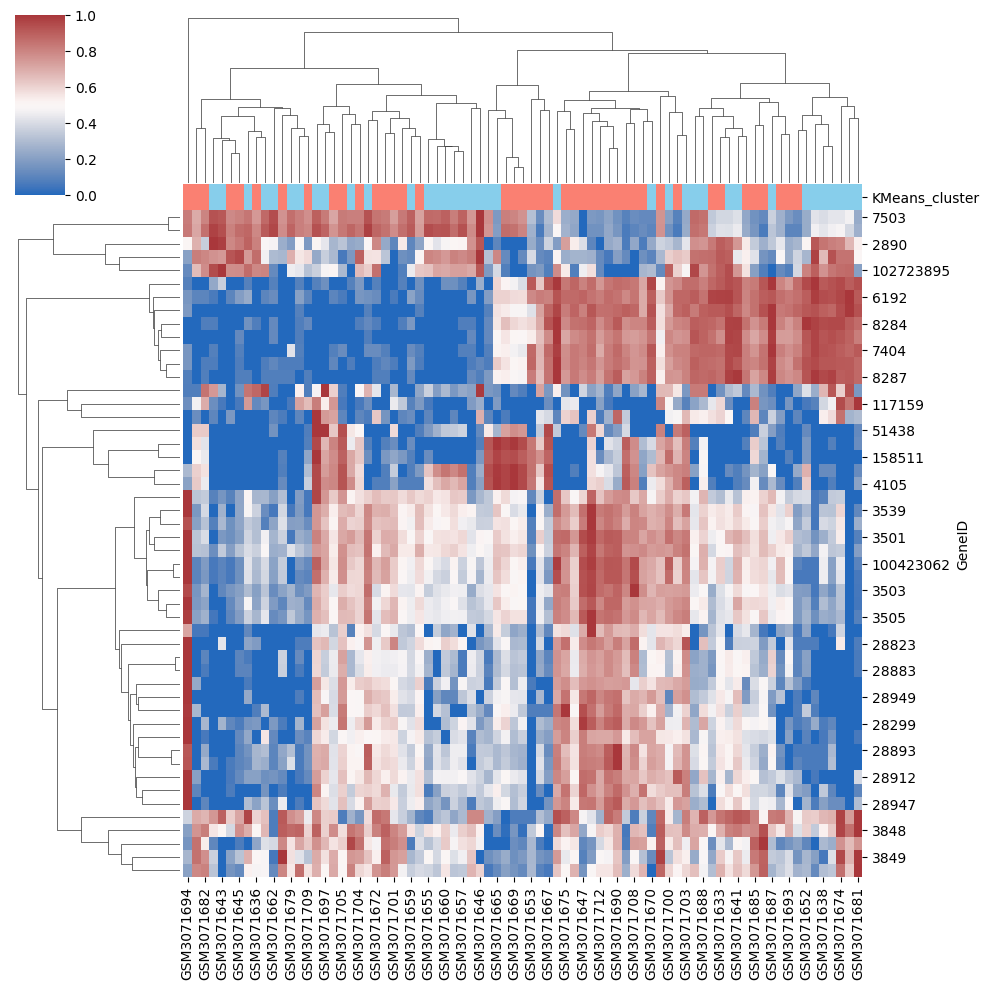

In [22]:
output_path = r"C:\Users\Aina Rif'ah\Downloads\INTERNSHIP\PROJECT 2\results\cluster_heatmap.png"

sns.clustermap(
    expr_top,
    col_colors=metadata["KMeans_cluster"].map({0: "skyblue", 1: "salmon"}),
    cmap="vlag",
    standard_scale=0,
    figsize=(10, 10)
)

plt.savefig(output_path, dpi=300)
plt.show()


In [24]:
metadata.to_csv(
    "C:/Users/Aina Rif'ah/Downloads/INTERNSHIP/PROJECT 2/data/processed/sample_clusters_week4.csv"
)


In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import pandas as pd

# Load log-normalized expression data
expr = pd.read_csv(
    "C:/Users/Aina Rif'ah/Downloads/INTERNSHIP/PROJECT 2/data/processed/GSE112509_log_normalized.csv",
    index_col=0
)

# Load metadata
metadata = pd.read_csv(
    "C:/Users/Aina Rif'ah/Downloads/INTERNSHIP/PROJECT 2/data/processed/GSE112509_metadata.csv",
    index_col=0
)

# Samples × genes matrix (REQUIRED)
X = expr.T

X.shape


(79, 29830)

In [6]:
from sklearn.cluster import KMeans

# Choose number of clusters (start with 2–4; 3 is reasonable)
k = 3

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

cluster_labels[:10]


C:\BLAST\envs\varpred\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([1, 1, 1, 1, 1, 1, 1, 1, 2, 1], dtype=int32)

In [8]:
cluster_df = pd.DataFrame(index=X.index)
cluster_df["Cluster"] = cluster_labels
cluster_df["Condition"] = metadata.loc[X.index, "condition"].values

cluster_df.head()


,Cluster,Condition
GSM3071633,1,Benign
GSM3071634,1,Benign
GSM3071635,1,Benign
GSM3071636,1,Benign
GSM3071637,1,Benign


In [10]:
from sklearn.decomposition import PCA
import pandas as pd

# Recompute PCA for visualization (samples × genes matrix X already exists)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

pca_df = pd.DataFrame(
    pca_result,
    columns=["PC1", "PC2"],
    index=X.index
)

pca_df.head()


,PC1,PC2
GSM3071633,-18.787524,-73.555037
GSM3071634,-148.785087,-154.860698
GSM3071635,-26.833356,-95.592801
GSM3071636,-144.715479,-111.653258
GSM3071637,-8.315532,-115.152877


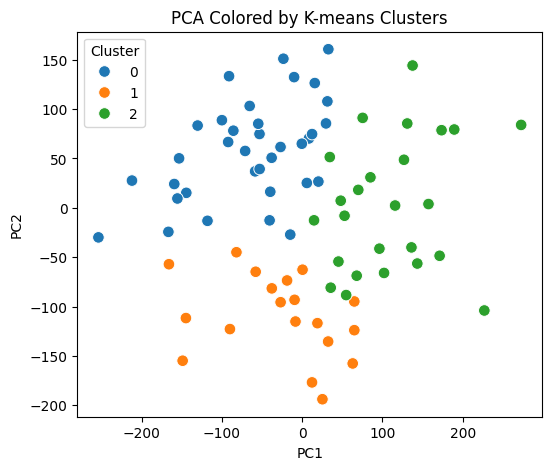

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.scatterplot(
    x=pca_df["PC1"],
    y=pca_df["PC2"],
    hue=cluster_df["Cluster"],
    palette="tab10",
    s=70
)

plt.title("PCA Colored by K-means Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [12]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X, cluster_labels)
print(f"Silhouette Score (k={k}): {sil_score:.3f}")


Silhouette Score (k=3): 0.096


In [13]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(X, cluster_labels)
print(f"Davies–Bouldin Index (k={k}): {db_score:.3f}")


Davies–Bouldin Index (k=3): 2.307


In [14]:
pd.crosstab(cluster_df["Cluster"], cluster_df["Condition"])


Condition,Benign,Melanoma
Cluster,,
0,5,30
1,13,6
2,5,20


In [15]:
from scipy.cluster.hierarchy import linkage, dendrogram

linkage_matrix = linkage(X, method="ward")


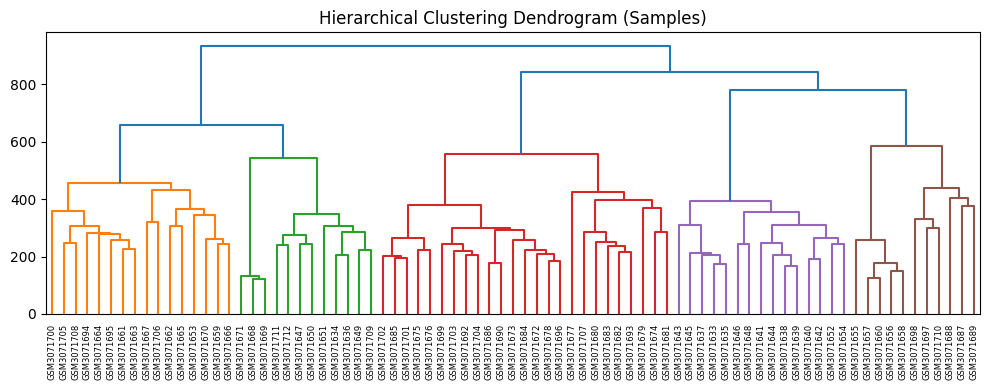

In [16]:
plt.figure(figsize=(10,4))
dendrogram(
    linkage_matrix,
    labels=X.index,
    leaf_rotation=90,
    leaf_font_size=6
)
plt.title("Hierarchical Clustering Dendrogram (Samples)")
plt.tight_layout()
plt.show()


In [18]:
cluster_df.to_csv("C:/Users/Aina Rif'ah/Downloads/INTERNSHIP/PROJECT 2/data/processed/sample_clusters_week4.csv")
